In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter, dataset_load
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
path = kagglehub.dataset_download("navjotkaushal/human-vs-ai-generated-essays")
print("Path to dataset files:", path)
print("Name of the .csv file:", os.listdir(path))

Path to dataset files: /home/agata/.cache/kagglehub/datasets/navjotkaushal/human-vs-ai-generated-essays/versions/1
Name of the .csv file: ['balanced_ai_human_prompts.csv']


In [3]:
file_path = "balanced_ai_human_prompts.csv"

In [4]:
df = dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "navjotkaushal/human-vs-ai-generated-essays",
    file_path
)

In [5]:
print(df.columns)

Index(['text', 'generated'], dtype='object')


In [6]:
print(df.head())

                                                text  generated
0  Machine learning, a subset of artificial intel...          1
1  A decision tree, a prominent machine learning ...          1
2  Education, a cornerstone of societal progress,...          1
3  Computers, the backbone of modern technology, ...          1
4  Chess, a timeless game of strategy and intelle...          1


In [7]:
df["generated"].value_counts()

generated
1    1375
0    1375
Name: count, dtype: int64

### Data Preprocessing

In [8]:
# Checking if there are any tags
mask = df["text"].str.contains(r'(?:<[^>]+>|\[.*?\]|\{.*?\})', regex=True)
print(df[mask].head())


Empty DataFrame
Columns: [text, generated]
Index: []


In [9]:
print(df["text"][0])

Machine learning, a subset of artificial intelligence, has rapidly emerged as a transformative force, revolutionizing industries and redefining the possibilities of technology. At its core, machine learning enables computers to learn from data and make informed decisions without explicit programming, with applications ranging from image recognition and language processing to autonomous systems. As machine learning continues to advance, it brings both opportunities and challenges, with issues of bias, transparency, and privacy demanding careful consideration. The impact of machine learning is profound, shaping a future where intelligent systems contribute to efficiency, innovation, and a more interconnected world.


In [10]:
# Preprocessing
def preprocess_text(text):
    text = str(text).lower()                        
    text = re.sub(r"http\S+|www\S+", "", text)       
    text = re.sub(r"[^a-z\s]", "", text)            
    text = re.sub(r"\s+", " ", text).strip()         
    words = text.split()
    return " ".join(words)
    
    return text

# Applying preprocessing
df["clean_text"] = df["text"].apply(preprocess_text)

print(df["clean_text"][0])

machine learning a subset of artificial intelligence has rapidly emerged as a transformative force revolutionizing industries and redefining the possibilities of technology at its core machine learning enables computers to learn from data and make informed decisions without explicit programming with applications ranging from image recognition and language processing to autonomous systems as machine learning continues to advance it brings both opportunities and challenges with issues of bias transparency and privacy demanding careful consideration the impact of machine learning is profound shaping a future where intelligent systems contribute to efficiency innovation and a more interconnected world


### TF-IDF Vectorizer

In [11]:
# Vectorizing words
vectorizer = TfidfVectorizer(
    token_pattern=r'(?u)\b[a-z]{2,}\b',  # only words with 2 letters minimum
    ngram_range=(1, 2),
    max_features=50000,
)
X_tfidf = vectorizer.fit_transform(df["clean_text"])

print("TF-IDF matrix shape:", X_tfidf.shape)
print("Sample features:", vectorizer.get_feature_names_out()[:50])


TF-IDF matrix shape: (2750, 50000)
Sample features: ['aa' 'abe to' 'abide' 'abide by' 'abilities' 'ability' 'ability to'
 'able' 'able for' 'able to' 'aboliished' 'abolish' 'abolish electoral'
 'abolish it' 'abolish the' 'abolish thee' 'abolish this' 'abolished'
 'abolished and' 'abolished as' 'abolished because' 'abolished due'
 'abolished for' 'abolished in' 'abolished is' 'abolished it'
 'abolished the' 'abolished while' 'abolishes' 'abolishing'
 'abolishing it' 'abolishing the' 'abolishment' 'abolishment of' 'abouit'
 'about' 'about all' 'about an' 'about and' 'about artificial'
 'about astrophysics' 'about autonomous' 'about because' 'about being'
 'about blockchain' 'about but' 'about buying' 'about car' 'about carfree'
 'about cars']


### Data Split

In [12]:
# Data split into train/test
X = X_tfidf
y = df["generated"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2200, 50000)
Test shape: (550, 50000)


### Logistic Regression

In [13]:
# Training Logistic Regression
lg_clf = LogisticRegression()
lg_clf.fit(X_train, y_train)

# Prediction and evaluation
y_pred_train = lg_clf.predict(X_train)
y_pred_test = lg_clf.predict(X_test)

print("\nAccuracy (train):", accuracy_score(y_train, y_pred_train))
print("Accuracy (test):", accuracy_score(y_test, y_pred_test))
print("\nClassification report (test):\n", classification_report(y_test, y_pred_test))


Accuracy (train): 0.9972727272727273
Accuracy (test): 0.9945454545454545

Classification report (test):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       275
           1       1.00      0.99      0.99       275

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550



In [14]:
# Cross-validation
scores = cross_val_score(lg_clf, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracies:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation accuracies: [0.88363636 0.99272727 0.99636364 0.99818182 0.99818182]
Mean CV accuracy: 0.9738181818181818


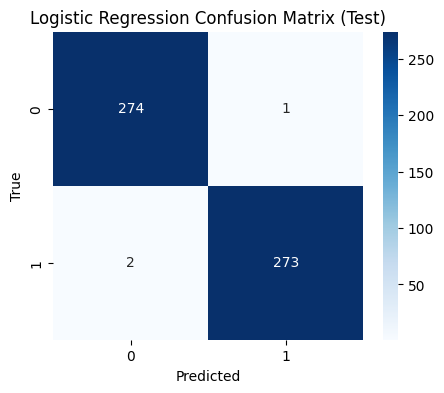

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=lg_clf.classes_)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=lg_clf.classes_, yticklabels=lg_clf.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix (Test)")
plt.show()

### Support Vector Machine

In [16]:
# Training SVM
svm_clf = LinearSVC(random_state=42, max_iter=5000)
svm_clf.fit(X_train, y_train)

# Prediction and evaluation
y_pred_train = svm_clf.predict(X_train)
y_pred_test = svm_clf.predict(X_test)

print("\nAccuracy (train):", accuracy_score(y_train, y_pred_train))
print("Accuracy (test):", accuracy_score(y_test, y_pred_test))
print("\nClassification report (test):\n", classification_report(y_test, y_pred_test))



Accuracy (train): 1.0
Accuracy (test): 0.9981818181818182

Classification report (test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       275

    accuracy                           1.00       550
   macro avg       1.00      1.00      1.00       550
weighted avg       1.00      1.00      1.00       550



In [17]:
# Cross-validation
scores = cross_val_score(svm_clf, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracies:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation accuracies: [0.84545455 1.         1.         0.99818182 0.99818182]
Mean CV accuracy: 0.9683636363636363


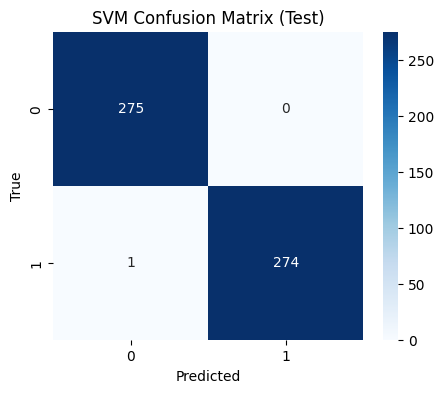

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=svm_clf.classes_)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix (Test)")
plt.show()

### Accuracy Comparison of Models

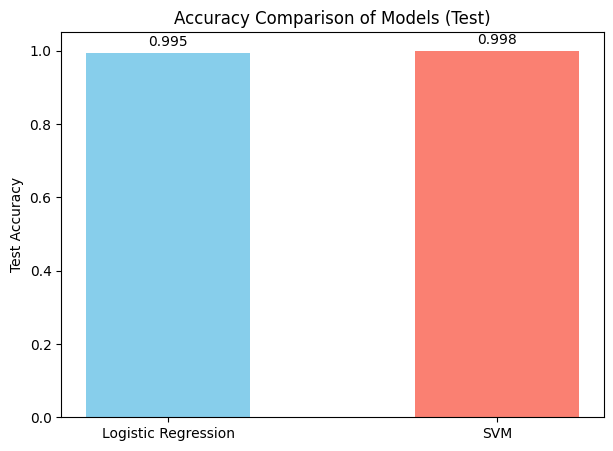

In [19]:
# Test accuracy values
test_accuracies = [
    accuracy_score(y_test, lg_clf.predict(X_test)),
    accuracy_score(y_test, svm_clf.predict(X_test))
]

models = ['Logistic Regression', 'SVM']

# Plot
x = np.arange(len(models))  # positions
width = 0.5  # bar width

fig, ax = plt.subplots(figsize=(7,5))
bars = ax.bar(x, test_accuracies, width, color=['skyblue', 'salmon'])

# Labels and title
ax.set_ylabel('Test Accuracy')
ax.set_title('Accuracy Comparison of Models (Test)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


### Top features

In [20]:
# Extracting top features of each class

# Coefficients for classes (LinearSVC has shape: [n_classes-1, n_features])
coef = svm_clf.coef_.toarray() if hasattr(svm_clf.coef_, "toarray") else svm_clf.coef_

# Feature names from TF-IDF
features = vectorizer.get_feature_names_out()

# If binary classification (0=human, 1=AI)
# Positive coefficients → features typical for AI
coef_ai = coef[0]  

# Create a DataFrame for easier analysis
df_coef = pd.DataFrame({"feature": features, "coef": coef_ai})

# Sort features by influence
top_ai = df_coef.sort_values(by="coef", ascending=False).head(20)
top_human = df_coef.sort_values(by="coef").head(20)

# Print results
print("Top 20 features indicative of AI essays:")
print(top_ai)

print("\nTop 20 features indicative of human essays:")
print(top_human)


Top 20 features indicative of AI essays:
            feature      coef
41695   the context  0.519545
10428    context of  0.519545
10427       context  0.518858
21532           its  0.379924
9101         coffee  0.366274
26201       natures  0.362556
8261          chess  0.337929
8019     challenges  0.322185
40875    technology  0.303788
14496        energy  0.297355
15452   exploration  0.276037
40963     testament  0.272837
40964  testament to  0.272837
32021   performance  0.272562
40539   sustainable  0.264970
14824       ethical  0.263225
16344       for its  0.256013
40475       sunsets  0.245992
37569       science  0.243012
14788         essay  0.242850

Top 20 features indicative of human essays:
         feature      coef
44281         to -1.037352
6893         car -0.874402
45006       tohe -0.833403
41484        the -0.801361
7301        cars -0.799918
42687       thee -0.760918
635          ahe -0.739927
31539     people -0.735875
21500       ithe -0.720948
9142     colle

### User Input Prediction

In [24]:
def classify_text(text, vectorizer, model):
    # Preprocessing
    def preprocess_text_single(text):
        text = str(text).lower()                        
        text = re.sub(r"http\S+|www\S+", "", text)       
        text = re.sub(r"[^a-z\s]", "", text)            
        text = re.sub(r"\s+", " ", text).strip()         
        words = text.split()
        return " ".join(words)

    clean_text = preprocess_text_single(text)
    
    # TF-IDF transform
    X_input = vectorizer.transform([clean_text])
    
    # Prediction
    pred_class = model.predict(X_input)[0]
    
    # Map 0/1 to human/AI-generated
    class_label = "human" if pred_class == 0 else "AI-generated"
    
    # Confidence
    decision = model.decision_function(X_input)[0]
    confidence = 1 / (1 + np.exp(-abs(decision))) * 100
    
    return class_label, confidence

# User input
user_text = input("Enter an essay text to classify (human or AI):\n")

class_label, confidence = classify_text(user_text, vectorizer, svm_clf)

print(f"\nPredicted class: {class_label}")
print(f"Confidence: {confidence:.2f}%")


Enter an essay text to classify (human or AI):
 Recently, there have been plenty of discussions and debates about punishments for young offenders. More and more people are demanding some changes in the law. They claim that the punishments for underage criminals should be harsher. I don’t agree with this idea, because I consider that the law in our country is correct and it doesn’t need to be modified.  Primarily, the proponents of the aggravation of punishments believe it will be safer if the fines are more severe. However, isolating young felons is just a short-term solution. In fact, putting them into prisons or juvenile detention centers for too long would have a negative impact on their future lives. Young people should be more integrated to society instead. Otherwise, they would not be taught how to live and behave among people. If they spent a big part of their childhood among other young criminals, they may become even more aggressive and dangerous as adults.  Additionally, the 


Predicted class: human
Confidence: 65.72%
